**Data Cleaning**

In [3]:
!pip install statsmodels
!pip install openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
import seaborn as sns

In [4]:
df=pd.read_excel("north_india_agg_27march.xlsx")

In [5]:
df.isnull().sum()

,0
Date,4
Rohu_Small_MarketF,413
Catla_Small_MarketF,407
Grass_Carp_Small_MarketF,411
Common_Carp_Small_MarketF,408
...,...
Common_Carp_Large_MarketG,291
Grass_Carp_Medium_MarketG,381
Grass_Carp_Large_MarketG,316
Pangas_Catfish_Medium_MarketG,392


In [6]:
df.shape

(436, 95)

In [7]:
df.dropna(subset=['Date'], inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y',errors='coerce')
full_dates = pd.DataFrame({'Date': pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')})
df = full_dates.merge(df, on='Date', how='left')
df.set_index('Date',inplace=True)


In [8]:
df.isnull().sum()

,0
Rohu_Small_MarketF,409
Catla_Small_MarketF,403
Grass_Carp_Small_MarketF,407
Common_Carp_Small_MarketF,404
Roopchand_Small_MarketF,406
...,...
Common_Carp_Large_MarketG,287
Grass_Carp_Medium_MarketG,377
Grass_Carp_Large_MarketG,312
Pangas_Catfish_Medium_MarketG,388


In [9]:
df.shape

(432, 94)

In [10]:
df.replace(0, np.nan, inplace=True)
df = df.interpolate(method="polynomial",order=2)
df = df.interpolate(method="linear")
df= df.ffill().bfill()

In [11]:
null_columns = df.isna().any()

print(null_columns[null_columns == True].index)

Index([], dtype='object')


In [12]:
df.shape

(432, 94)

In [13]:
column_names=df.columns

In [14]:
for i in column_names:
  df[i+"_Cbrt"]=np.cbrt(df[i].clip(lower=0))

**Determining stationarity of Data**

In [15]:
def stationary_test(dataframe,column):
  temp_df=dataframe.copy()
  temp_df.dropna(inplace=True)
  print("For the column {}".format(column))
  adftest=adfuller(temp_df[column],autolag='AIC')
  stats=pd.Series(adftest[1],index=['p-value'])
  print(stats)


In [16]:
df_dummy=df.copy()
for col in df_dummy.columns:
  stationary_test(df_dummy,col)

For the column Rohu_Small_MarketF
p-value    0.196412
dtype: float64
For the column Catla_Small_MarketF
p-value    0.000339
dtype: float64
For the column Grass_Carp_Small_MarketF
p-value    0.06192
dtype: float64
For the column Common_Carp_Small_MarketF
p-value    0.112093
dtype: float64
For the column Roopchand_Small_MarketF
p-value    0.034209
dtype: float64
For the column Pangas_Catfish_Small_MarketF
p-value    0.129961
dtype: float64
For the column Pangas_Catfish_Large_MarketC
p-value    0.000023
dtype: float64
For the column Pangas_Catfish_Medium_MarketC
p-value    0.000023
dtype: float64
For the column Pangas_Catfish_Small_MarketC
p-value    0.002684
dtype: float64
For the column Catla_Large_MarketC
p-value    0.000002
dtype: float64
For the column Catla_Medium_MarketC
p-value    0.000015
dtype: float64
For the column Catla_Small_MarketC
p-value    0.000015
dtype: float64
For the column Rohu_Large_MarketC
p-value    7.276518e-07
dtype: float64
For the column Rohu_Medium_MarketC
p

In [17]:
df.shape

(432, 188)

In [18]:

import matplotlib.pyplot as plt

def plot_series(historical_data, forecast_data):
    columns = column_names
    plt.figure(figsize=(16, 100))

    for i, col in enumerate(columns, 1):
        plt.subplot(32, 3, i)
        plt.plot(historical_data.index, historical_data[col], label='Historical', color='blue')
        plt.plot(forecast_data.index, forecast_data[col], label='Forecast', linestyle='--', color='red')
        plt.title(col.replace('_', ' '))
        plt.xticks(rotation=45)
        plt.ylim(0,1200)
        plt.legend()


    plt.tight_layout()
    plt.show()


In [19]:

df.columns

Index(['Rohu_Small_MarketF', 'Catla_Small_MarketF', 'Grass_Carp_Small_MarketF',
       'Common_Carp_Small_MarketF', 'Roopchand_Small_MarketF',
       'Pangas_Catfish_Small_MarketF', 'Pangas_Catfish_Large_MarketC',
       'Pangas_Catfish_Medium_MarketC', 'Pangas_Catfish_Small_MarketC',
       'Catla_Large_MarketC',
       ...
       'Catla_Medium_MarketG_Cbrt', 'Catla_Large_MarketG_Cbrt',
       'Roopchand_Medium_MarketG_Cbrt', 'Roopchand_Large_MarketG_Cbrt',
       'Common_Carp_Medium_MarketG_Cbrt', 'Common_Carp_Large_MarketG_Cbrt',
       'Grass_Carp_Medium_MarketG_Cbrt', 'Grass_Carp_Large_MarketG_Cbrt',
       'Pangas_Catfish_Medium_MarketG_Cbrt',
       'Pangas_Catfish_Large_MarketG_Cbrt'],
      dtype='object', length=188)

In [20]:
0.8*df.shape[0]

345.6

**Dividing Data into Training and Testing**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 77.79
MSE: 144822.67
RMSE: 380.56
MAPE: 48.63%
sMAPE: 27.08%


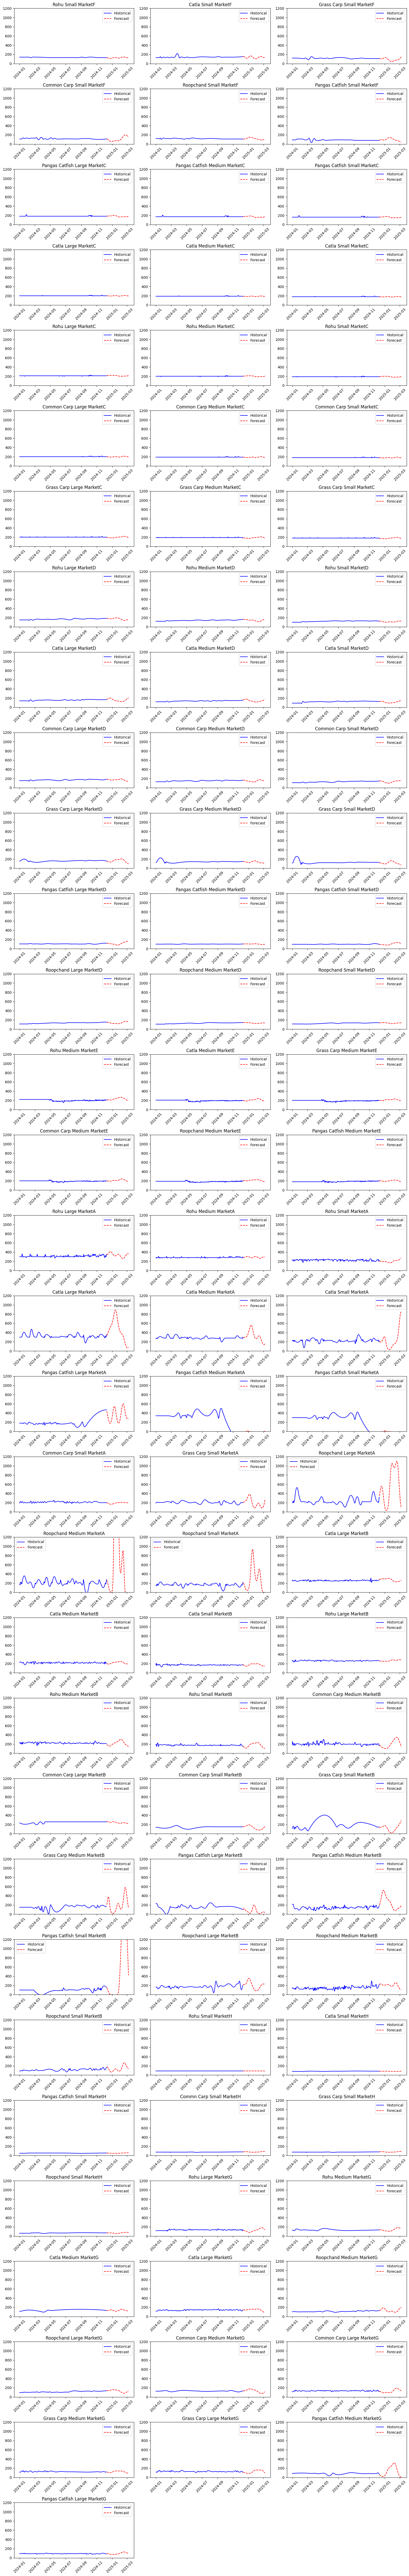

In [21]:
train=df[column_names].iloc[0:345]
test=df[column_names].iloc[345:]
train=np.cbrt(train)
test=np.cbrt(test)
scaler=StandardScaler()

train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=train.columns, index=train.index)
lag_order=1
model = VAR(train_scaled)
results=model.fit(maxlags=lag_order,method='ols')
forecast_scaled = results.forecast(train_scaled.values[-lag_order:], steps=len(test))
forecast = scaler.inverse_transform(forecast_scaled)
forecast_data = pd.DataFrame(forecast, index=test.index, columns=train.columns)
train=np.power(train,3)
test=np.power(test,3)
forecast_data=np.power(forecast_data,3)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(test, forecast_data)
mse = mean_squared_error(test, forecast_data)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast_data) / test)) * 100
smape = np.mean(2 * np.abs(test - forecast_data) / (np.abs(test) + np.abs(forecast_data))) * 100

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"sMAPE: {smape:.2f}%")
plot_series(train,forecast_data)

**Using the Entire Data for Training and Testing**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 30.58
RMSE: 111.13
MAPE: 35.58%
sMAPE: 14.17%


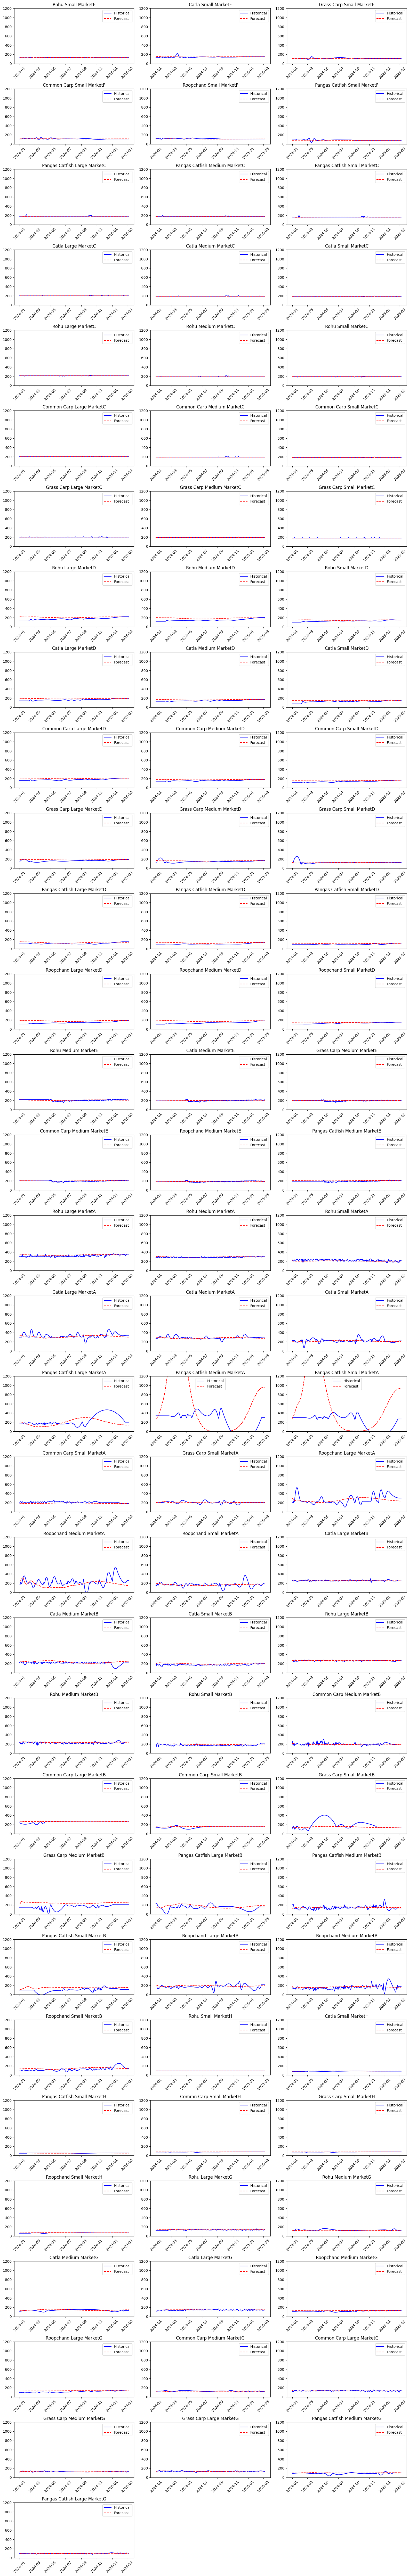

In [22]:
train=df[column_names]
test=df[column_names]
train=np.cbrt(train)
test=np.cbrt(test)
scaler=StandardScaler()

train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=train.columns, index=train.index)
lag_order=1
model = VAR(train_scaled)
results=model.fit(maxlags=lag_order,method='ols')
forecast_scaled = results.forecast(train_scaled.values[-lag_order:], steps=len(test))
forecast = scaler.inverse_transform(forecast_scaled)
forecast_data = pd.DataFrame(forecast, index=test.index, columns=train.columns)
train=np.power(train,3)
test=np.power(test,3)
forecast_data=np.power(forecast_data,3)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
rmse=np.sqrt(mean_squared_error(test,forecast_data))
mae = mean_absolute_error(test,forecast_data)
mape = np.mean(np.abs((test - forecast_data) / test)) * 100
smape = np.mean(2 * np.abs(test - forecast_data) / (np.abs(test) + np.abs(forecast_data))) * 100
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"sMAPE: {smape:.2f}%")
plot_series(train,forecast_data)
with open('model.pkl','wb') as file:
  pickle.dump(results,file)

Function to be used for Deployment

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import pickle
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from datetime import datetime


In [24]:
df.columns

Index(['Rohu_Small_MarketF', 'Catla_Small_MarketF', 'Grass_Carp_Small_MarketF',
       'Common_Carp_Small_MarketF', 'Roopchand_Small_MarketF',
       'Pangas_Catfish_Small_MarketF', 'Pangas_Catfish_Large_MarketC',
       'Pangas_Catfish_Medium_MarketC', 'Pangas_Catfish_Small_MarketC',
       'Catla_Large_MarketC',
       ...
       'Catla_Medium_MarketG_Cbrt', 'Catla_Large_MarketG_Cbrt',
       'Roopchand_Medium_MarketG_Cbrt', 'Roopchand_Large_MarketG_Cbrt',
       'Common_Carp_Medium_MarketG_Cbrt', 'Common_Carp_Large_MarketG_Cbrt',
       'Grass_Carp_Medium_MarketG_Cbrt', 'Grass_Carp_Large_MarketG_Cbrt',
       'Pangas_Catfish_Medium_MarketG_Cbrt',
       'Pangas_Catfish_Large_MarketG_Cbrt'],
      dtype='object', length=188)

In [25]:
def get_fish_column(fish, size, market):

    fish_mapping = {
        "Pangas Catfish": "Pangas_Catfish",
        "Catla": "Catla",
        "Rohu": "Rohu",
        "Common Carp": "Common_Carp",
        "Grass Carp": "Grass_Carp",
        "Roopchand": "Roopchand"
    }


    size_mapping = {
        "Small": "Small",
        "Medium": "Medium",
        "Large": "Large"
    }

    market_mapping = {
        "DDA Market": "A",
        "Ghazipur Market": "B",
        "Barnala Market": "C",
        "Ludhiana Market": "D",
        "Sunam Dhuri market": "E",
        "Amritsar Market": "F",
        "Faridabad Market": "G",
        "yamuna nagar Market": "H"
    }

    if fish in fish_mapping and size in size_mapping and market in market_mapping:
        return f"{fish_mapping[fish]}_{size_mapping[size]}_Market{market_mapping[market]}"
    else:
        return "Incorrect Input"

In [26]:
def predict(fore_date,market,fish,size):
  train_data=pd.read_excel("north_india_agg_27march.xlsx")
  train_data.dropna(subset=['Date'], inplace=True)
  train_data['Date'] = pd.to_datetime(train_data['Date'], format='%d-%m-%Y',errors='coerce')
  full_dates = pd.DataFrame({'Date': pd.date_range(start=train_data['Date'].min(), end=train_data['Date'].max(), freq='D')})
  train_data = full_dates.merge(train_data, on='Date', how='left')
  train_data.set_index('Date',inplace=True)
  train_data.replace(0, np.nan, inplace=True)
  train_data = train_data.interpolate(method="polynomial",order=2)
  train_data = train_data.interpolate(method="linear")
  train_data= train_data.ffill().bfill()
  scaler=StandardScaler()
  train_scaled = pd.DataFrame(scaler.fit_transform(np.cbrt(train_data)),
                                columns=train_data.columns,
                                index=train_data.index)
  baseline_date=datetime.strptime("07-03-2025", "%d-%m-%Y")
  with open('model.pkl','rb') as file:
    model=pickle.load(file)
  if(fore_date<baseline_date):
    return "enter dates after 7th March,2025 only"
  steps=(fore_date-baseline_date).days
  lag_order = model.k_ar
  forecast_scaled = model.forecast(train_scaled.values[-lag_order:], steps=steps)
  forecast = scaler.inverse_transform(forecast_scaled)
  forecast_data = pd.DataFrame(forecast, columns=train_data.columns)
  forecast_data = np.power(forecast_data, 3)
  fish_and_size=""
  fish_and_size=get_fish_column(fish,size,market)
  if fish_and_size not in forecast_data.columns:
    return "Incorrect Input"
  fish_data=forecast_data[fish_and_size]
  forecast_dates=[]
  final_forecast_data={
      'Date':[],
      'Prediction':[]
  }
  from datetime import timedelta
  print("Forecast of Fish Prices ")
  for i in range(len(fish_data)):
    current_date = baseline_date + timedelta(days=i+1)
    print("Date {} Prediction {} Rupees".format(current_date,np.round(fish_data[i])))
    forecast_dates.append(baseline_date + timedelta(days=i+1))
    final_forecast_data['Date'].append(current_date)
    final_forecast_data['Prediction'].append(np.round(fish_data[i]))
  plt.plot(train_data.index,train_data[fish_and_size],label="Historical Data",color="blue")
  plt.plot(forecast_dates,fish_data,label="Forecast Data",linestyle="--",color="red")
  plt.xticks(rotation=45)
  plt.ylim(0,500)
  plt.legend()
  plt.show()





Forecast of Fish Prices 
Date 2025-03-08 00:00:00 Prediction 130.0 Rupees
Date 2025-03-09 00:00:00 Prediction 130.0 Rupees
Date 2025-03-10 00:00:00 Prediction 130.0 Rupees
Date 2025-03-11 00:00:00 Prediction 130.0 Rupees
Date 2025-03-12 00:00:00 Prediction 130.0 Rupees
Date 2025-03-13 00:00:00 Prediction 130.0 Rupees
Date 2025-03-14 00:00:00 Prediction 130.0 Rupees
Date 2025-03-15 00:00:00 Prediction 130.0 Rupees
Date 2025-03-16 00:00:00 Prediction 130.0 Rupees
Date 2025-03-17 00:00:00 Prediction 130.0 Rupees
Date 2025-03-18 00:00:00 Prediction 130.0 Rupees
Date 2025-03-19 00:00:00 Prediction 130.0 Rupees
Date 2025-03-20 00:00:00 Prediction 130.0 Rupees
Date 2025-03-21 00:00:00 Prediction 129.0 Rupees
Date 2025-03-22 00:00:00 Prediction 129.0 Rupees
Date 2025-03-23 00:00:00 Prediction 129.0 Rupees
Date 2025-03-24 00:00:00 Prediction 129.0 Rupees
Date 2025-03-25 00:00:00 Prediction 128.0 Rupees
Date 2025-03-26 00:00:00 Prediction 128.0 Rupees
Date 2025-03-27 00:00:00 Prediction 128.0 Ru

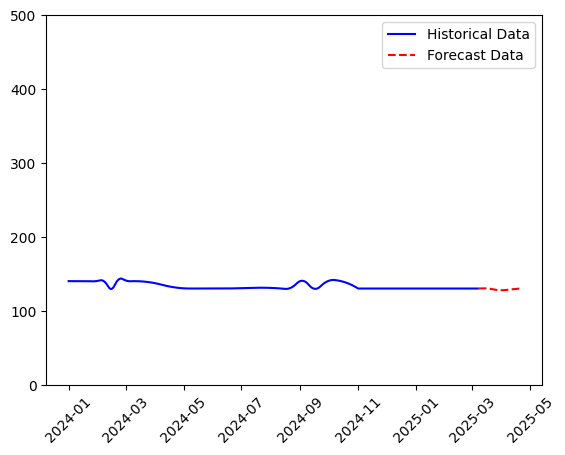

In [27]:
predict(datetime.strptime("20-04-2025", "%d-%m-%Y"),"Amritsar Market","Rohu","Small")

Forecast of Fish Prices 
Date 2025-03-08 00:00:00 Prediction 190.0 Rupees
Date 2025-03-09 00:00:00 Prediction 190.0 Rupees
Date 2025-03-10 00:00:00 Prediction 190.0 Rupees
Date 2025-03-11 00:00:00 Prediction 190.0 Rupees
Date 2025-03-12 00:00:00 Prediction 190.0 Rupees
Date 2025-03-13 00:00:00 Prediction 190.0 Rupees
Date 2025-03-14 00:00:00 Prediction 190.0 Rupees
Date 2025-03-15 00:00:00 Prediction 190.0 Rupees
Date 2025-03-16 00:00:00 Prediction 190.0 Rupees
Date 2025-03-17 00:00:00 Prediction 190.0 Rupees
Date 2025-03-18 00:00:00 Prediction 190.0 Rupees
Date 2025-03-19 00:00:00 Prediction 190.0 Rupees
Date 2025-03-20 00:00:00 Prediction 190.0 Rupees
Date 2025-03-21 00:00:00 Prediction 190.0 Rupees
Date 2025-03-22 00:00:00 Prediction 190.0 Rupees
Date 2025-03-23 00:00:00 Prediction 190.0 Rupees
Date 2025-03-24 00:00:00 Prediction 190.0 Rupees
Date 2025-03-25 00:00:00 Prediction 190.0 Rupees
Date 2025-03-26 00:00:00 Prediction 190.0 Rupees
Date 2025-03-27 00:00:00 Prediction 190.0 Ru

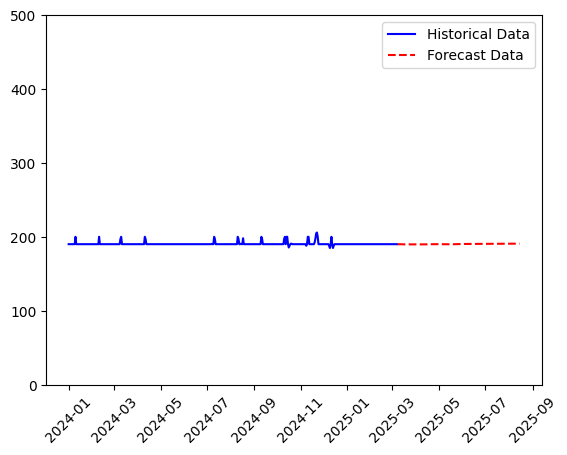

In [28]:
predict(datetime.strptime("15-08-2025", "%d-%m-%Y"),"Barnala Market","Grass Carp","Medium")

Forecast of Fish Prices 
Date 2025-03-08 00:00:00 Prediction 195.0 Rupees
Date 2025-03-09 00:00:00 Prediction 195.0 Rupees
Date 2025-03-10 00:00:00 Prediction 195.0 Rupees
Date 2025-03-11 00:00:00 Prediction 195.0 Rupees
Date 2025-03-12 00:00:00 Prediction 195.0 Rupees
Date 2025-03-13 00:00:00 Prediction 195.0 Rupees
Date 2025-03-14 00:00:00 Prediction 195.0 Rupees
Date 2025-03-15 00:00:00 Prediction 194.0 Rupees
Date 2025-03-16 00:00:00 Prediction 194.0 Rupees
Date 2025-03-17 00:00:00 Prediction 194.0 Rupees
Date 2025-03-18 00:00:00 Prediction 193.0 Rupees
Date 2025-03-19 00:00:00 Prediction 193.0 Rupees
Date 2025-03-20 00:00:00 Prediction 193.0 Rupees
Date 2025-03-21 00:00:00 Prediction 193.0 Rupees
Date 2025-03-22 00:00:00 Prediction 193.0 Rupees
Date 2025-03-23 00:00:00 Prediction 194.0 Rupees
Date 2025-03-24 00:00:00 Prediction 194.0 Rupees
Date 2025-03-25 00:00:00 Prediction 194.0 Rupees
Date 2025-03-26 00:00:00 Prediction 194.0 Rupees
Date 2025-03-27 00:00:00 Prediction 194.0 Ru

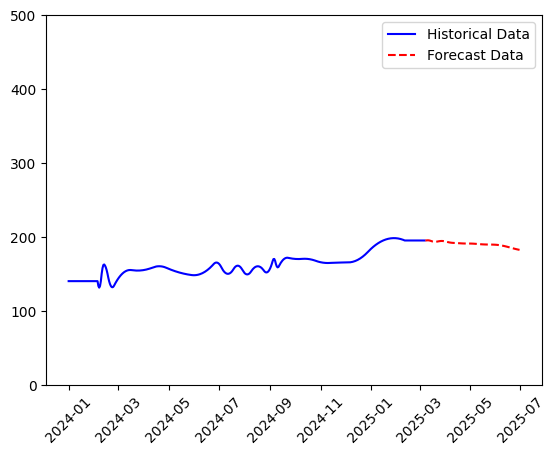

In [29]:
predict(datetime.strptime("30-06-2025", "%d-%m-%Y"),"Ludhiana Market","Catla","Large")